In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import matplotlib
import seaborn as sns
import sys
import os
from os import path
import yaml
import copy
from scipy import stats
from importlib import reload  

In [4]:
os.chdir('../..')

In [5]:
from mega_analysis.crosstab.mega_analysis.MEGA_ANALYSIS import MEGA_ANALYSIS
from mega_analysis.Sankey_Functions import normalise_localisation_cols_OTHER_SplitTL
from mega_analysis.crosstab.mega_analysis.QUERY_SEMIOLOGY import QUERY_SEMIOLOGY
from mega_analysis.crosstab.NORMALISE_TO_LOCALISING_VALUES import NORMALISE_TO_LOCALISING_VALUES
from mega_analysis.crosstab.file_paths import file_paths
from mega_analysis.crosstab.lobe_top_level_hierarchy_only import top_level_lobes
from mega_analysis.crosstab.hierarchy_dictionaries import temporal_postcodes
from mega_analysis.semiology import recursive_items

In [229]:
from scripts.figures import interogate_queries, get_region_names, plot_forest_plot
from plot_forest_plot import plot_proportion_ci_forest_plot

In [226]:
reload(interogate_queries)

<module 'scripts.figures.interogate_queries' from '/Volumes/Encrypted/Semiology-Visualisation-Tool/scripts/figures/interogate_queries.py'>

# Define lists & file paths

In [11]:
repo_dir, resources_dir, excel_path, semiology_dict_path = file_paths()

Semio2Brain_Database = r'/Volumes/Encrypted/Semiology-Visualisation-Tool/resources/__Semio2Brain Database v1.1.0.xlsx'

with open(semiology_dict_path) as f:
    SemioDict = yaml.load(f, Loader=yaml.FullLoader)

In [32]:
region_names = get_region_names.get()

In [18]:
semiology_list = list(recursive_items(SemioDict))

semiology_list_automatism_removed = semiology_list
automatism_subcategories = ['Automatism - Automotor Manual','Automatisms - Oral', 'Mimetic Automatisms', 'Automatism - Lower Limb - Non Hypermotor']
for subcategory in automatism_subcategories:
    semiology_list_automatism_removed.remove(subcategory)

# Get df from Excel sheet & query df

In [20]:
(original_df, 
df_ground_truth, df_study_type,
num_database_articles, num_database_patients, num_database_lat, num_database_loc) = \
                MEGA_ANALYSIS(Semio2Brain_Database)
print(original_df.shape)

(2576, 121)


In [56]:
df = copy.deepcopy(original_df)
raw_dfs = {
    'full': df,
    'spontaneous': df[df['Spontaneous Semiology (SS)'] == 'y'],
    'topology':  df[df['Spontaneous Semiology (SS)'] != 'y'],
}

In [59]:
def query_semiology_wrapper(df, semiology_list, semiology_dict_path):
    query_results = {}
    for semiology in semiology_list:
        query_inspection, num_query_lat, num_query_loc = QUERY_SEMIOLOGY(df,
                                                                     semiology_term=semiology,
                                                                     ignore_case=True,
                                                                     semiology_dict_path=semiology_dict_path,
                                                                     all_columns_wanted = True)
                                                                             # col1=col1, col2=col1)
            
        one_query_result = {
            'query_inspection': query_inspection,
            'num_query_lat': num_query_lat,
            'num_query_loc': num_query_loc
        }
        query_results[semiology] = one_query_result
    return query_results

In [51]:
query_results_not_normalised = {}
for key, df in raw_dfs.items():
    query_results_not_normalised[key] = query_semiology_wrapper(df, semiology_list_automatism_removed, semiology_dict_path)

In [71]:
normalised_df = normalise_localisation_cols_OTHER_SplitTL(copy.deepcopy(original_df))[0]
normalised_raw_dfs = {
    'full': normalised_df,
    'spontaneous': normalised_df[normalised_df['Spontaneous Semiology (SS)'] == 'y'],
    'topology':  normalised_df[normalised_df['Spontaneous Semiology (SS)'] != 'y'],
}

In [72]:
normalised_raw_dfs = {}
for key, df in raw_dfs.items():
    normalised_raw_dfs[key] = normalise_localisation_cols_OTHER_SplitTL(df)[0]

In [94]:
query_results_normalised = {}
for key, df in normalised_raw_dfs.items():
    query_results_normalised[key] = query_semiology_wrapper(df, semiology_list_automatism_removed, semiology_dict_path)

In [ ]:
# normalised_df[region_names['all']].sum(0)

In [95]:
query_results = {
    'not_normalised': query_results_not_normalised,
    'normalised': query_results_normalised,
}

In [79]:
def sort_semiologies_by_n(query_result, top_n = 0, include_n = False):
    """
    Get semiologies in order of most frequently seen, based on query results
    
    Input:
    - query_results: a dictionary where keys are semiologies and values are
    'query_inspection' for that semiology, as returned by QUERY_SEMIOLOGY
    (often query_results['not_normalised']['full'])
    - top_n can be used to get the n semiologies with the highest number of cases
    - include_n = True to return the frequency of each semiology
    """
    n_results = []
    for k, v in query_result.items():
        n_results.append(v['num_query_loc'])
    n_results = np.array(n_results)
    
    labels = list(query_result.keys())
    sorted_result = np.sort(n_results)
    sorted_index = np.argsort(n_results)
    sorted_labels = [labels[i] for i in sorted_index]
    if include_n:
        return tuple(zip(sorted_labels[-top_n:], sorted_result[-top_n:]))
    else:
        return sorted_labels[-top_n:]

In [80]:
sorted_semiologies = sort_semiologies_by_n(query_results['not_normalised']['full'])

---
# Figure 1 - proportions by semiology
---

In [228]:
plt.rc('font', size=8)          # controls default text sizes
plt.rc('axes', titlesize=9)     # fontsize of the axes title
plt.rc('axes', labelsize=9)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=7)    # fontsize of the tick labels
plt.rc('ytick', labelsize=7)    # fontsize of the tick labels
plt.rc('legend', fontsize=7)    # legend fontsize
plt.rc('figure', titlesize=10) 

In [83]:
legend_labels = ['ALl studies', 'Spontaneous Semiology only']
# colors = ['#009988', '#cc3311'] # green, red
colors = [sns.color_palette("Greys")[3], sns.color_palette()[0]] # greys
# colors =  [(0.5085736255286428, 0.5085736255286428, 0.5085736255286428, 0.5), matplotlib.colors.colorConverter.to_rgba('black', alpha=.5)] #greys, transparent
# colors = [sns.color_palette("Greens")[3], sns.color_palette("Greens")[5]] # greens
# colors = [sns.color_palette("Greys")[4], sns.color_palette("Greens")[5]] # grey-greens
plotter_settings = {
    'ls': 'none',
    'linewidth': 1,
    'marker': 'o',
    'markeredgewidth': 1,
    'markersize': 3.5,
#     'markerfacecolor': 'white',
#     'alpha': 0.5
}

In [253]:
axis='semiology'
regions_of_interest = region_names['of_interest_minus_tl']+region_names['low_level_temporal_of_interest']
semiologies_of_interest = sorted_semiologies[-20:]

processed_dfs = {}
for normalised_or_not, sub_query_results in query_results.items():
    processed_dfs[normalised_or_not] = {}
    for study_type, query_result in sub_query_results.items():
        processed_dfs[normalised_or_not][study_type] = interogate_queries.summarise_query(
            query_result,
            axis = 'semiology',
            region_names = region_names,
            confint_method = 'binomial',
            merge_temporal = False,
            other_regions_included = True,
            semiologies_of_interest = semiologies_of_interest,
            regions_of_interest = regions_of_interest,
            drop_other_semiology = True)

In [100]:
ax_titles = ['Epigastric',
             'Autonomic',
             'Olfactory',
             'Somatosensory',
             'Non-Specific Aura',
             'Tonic',
             'Dystonic',
             'Automatisms',
 'Dialeptic/LOA', 
 ]

y_names = ['Anterior Temporal',
 'Lateral Temporal',
 'Mesial Temporal',
 'Posterior Temporal',
 'Basal Temporal',
 'Cingulate Gyrus',
 'Parietal Lobe',
 'Frontal Lobe',
 'Insula',
 'Hypothalamus',
 'Occipital Lobe',
 'Interlobar Junctions+']

In [257]:
sns.set_style('darkgrid')
plot_proportion_ci_forest_plot(proportion_df_1 = processed_dfs['normalised']['full']['proportion'],
                               confint_df_1 = processed_dfs['normalised']['full']['confints'],
                               counts_df_1 = processed_dfs['not_normalised']['full']['counts'],
                               colors = colors,
                               plotter_settings = plotter_settings,
                               legend_labels = legend_labels,
                               proportion_df_2 = processed_dfs['normalised']['spontaneous']['proportion'],
                               confint_df_2 = processed_dfs['normalised']['spontaneous']['confints'],
                               counts_df_2 = processed_dfs['not_normalised']['spontaneous']['counts'],
                               y_labels = clean_labels(processed_dfs['normalised']['full']['proportion'].columns),
                               overlapping=False,
                               ax_titles = ax_titles ,
                              )

# plt.savefig('.png', dpi=300, pad_inches=0.5)

TypeError: can only concatenate list (not "tuple") to list

In [254]:
processed_dfs['normalised']['full']['proportion'].index

Index(['Epigastric', 'Fear-Anxiety', 'Psychic', 'Autonomous-Vegetative',
       'Olfactory', 'Visual - Elementary', 'Somatosensory',
       'Non-Specific Aura', 'Head or Body Turn', 'Head Version', 'Tonic',
       'Dystonic', 'Clonic', 'Hypermotor', 'Complex Behavioural',
       'Automatisms Combination - Manual LowerLimb Oral',
       'Vocalisation: Unintelligible Noises', 'Aphasia',
       'Ictal Speech: Formed Words', 'Dialeptic/LOA'],
      dtype='object')

In [ ]:
['Epigastric', 'Fear-Anxiety', 'Psychic', 'Autonomous-Vegetative',
       'Olfactory', 'Visual - Elementary', 'Somatosensory',
       'Non-Specific Aura', 'Head or Body Turn', 'Head Version', 'Tonic',
       'Dystonic', 'Clonic', 'Hypermotor', 'Complex Behavioural',
       'Automatisms Combination - Manual LowerLimb Oral',
       'Vocalisation: Unintelligible Noises', 'Aphasia',
       'Ictal Speech: Formed Words', 'Dialeptic/LOA'],

['Epigastric', 'Fear-Anxiety', 'Psychic', 'Autonomic',
       'Olfactory', 'Visual - Elementary', 'Somatosensory',
       'Non-Specific Aura', 'Head or Body Turn', 'Head Version', 'Tonic',
       'Dystonic', 'Clonic', 'Hypermotor', 'Complex Behavioural',
       'Automatisms','Unintelligible Noises', 'Aphasia',
       'Ictal Speech: Formed Words', 'Dialeptic/LOA'],

In [264]:
def clean_labels(labels):
    pre_localisation = ['Anterior (temporal pole)',
             'Lateral Temporal',
             'Mesial Temporal',
             'Posterior Temporal',
             'Basal (including Fusiform OTMG)',
             'Hypothalamus',
             'PL',
             'CING',
             'OL',
             'FL',
             'INSULA',
             'All other']

    post_localisation = ['Anterior Temporal',
     'Lateral Temporal',
     'Mesial Temporal',
     'Posterior Temporal',
     'Basal Temporal',
     'Hypothalamus',
     'Parietal Lobe',
     'Cingulate Gyrus',
     'Occipital Lobe',
     'Frontal Lobe',
     'Insula',
     'Interlobar Junctions+']
    
    pre_semiology = ['Epigastric', 'Fear-Anxiety', 'Psychic', 'Autonomous-Vegetative',
       'Olfactory', 'Visual - Elementary', 'Somatosensory',
       'Non-Specific Aura', 'Head or Body Turn', 'Head Version', 'Tonic',
       'Dystonic', 'Clonic', 'Hypermotor', 'Complex Behavioural',
       'Automatisms Combination - Manual LowerLimb Oral',
       'Vocalisation: Unintelligible Noises', 'Aphasia',
       'Ictal Speech: Formed Words', 'Dialeptic/LOA']
    
    post_semiology = ['Epigastric', 'Fear-Anxiety', 'Psychic', 'Autonomic',
       'Olfactory', 'Visual - Elementary', 'Somatosensory',
       'Non-Specific Aura', 'Head or Body Turn', 'Head Version', 'Tonic',
       'Dystonic', 'Clonic', 'Hypermotor', 'Complex Behavioural',
       'Automatisms','Unintelligible Noises', 'Aphasia',
       'Ictal Speech: Formed Words', 'Dialeptic/LOA']

    look_up_dict = dict(zip(pre_localisation+pre_semiology, post_localisation+post_semiology))

    return [look_up_dict[label] for label in labels]

In [265]:
clean_labels(processed_dfs['normalised']['full']['proportion'].index)

['Epigastric',
 'Fear-Anxiety',
 'Psychic',
 'Autonomic',
 'Olfactory',
 'Visual - Elementary',
 'Somatosensory',
 'Non-Specific Aura',
 'Head or Body Turn',
 'Head Version',
 'Tonic',
 'Dystonic',
 'Clonic',
 'Hypermotor',
 'Complex Behavioural',
 'Automatisms',
 'Unintelligible Noises',
 'Aphasia',
 'Ictal Speech: Formed Words',
 'Dialeptic/LOA']

In [233]:
os.getcwd()

'/Volumes/Encrypted/Semiology-Visualisation-Tool'

_______
# By zone
________

In [102]:
def plot_stacked_hbar(proportions_df, ax, ax_title=None, axis='semiology', y_labels=None, color_palette = sns.color_palette("Paired", 12, as_cmap=True)):
    if y_labels is not None:
        proportions_df.columns = y_labels
        
    if axis=='semiology':
        proportions_df=proportions_df
        xlabel = 'P(Localisation | Semiology)'
    elif axis=='zone':
        proportions_df=proportions_df.T
        xlabel = 'P(Semiology | Localisation)'
    else:
        raise ValueError('axis kwarg must be from {semiology, zone}')
    
    proportions_df[::-1].plot(kind='barh', colormap=color_palette, stacked=True,figsize=(10, 4), ax=ax)
    plt.gca().set_xlim((0,1))

    ax.title.set_text(ax_title)
    ax.set_xlabel(xlabel)

In [103]:
regions_of_interest = region_names['of_interest_minus_tl']+region_names['low_level_temporal_of_interest']
semiologies_of_interest = sorted_semiologies[-20:]
axis = 'zone'

processed_dfs = {}
for normalised_or_not, sub_query_results in query_results.items():
    processed_dfs[normalised_or_not] = {}
    for study_type, query_result in sub_query_results.items():
        processed_dfs[normalised_or_not][study_type] = interogate_queries.summarise_query(query_result,
                                                                      axis = axis,
                                                                      region_names = region_names,
                                                                      confint_method = 'binomial',
                                                                      merge_temporal = False,
                                                                      other_included = True,
                                                                      semiologies_of_interest = semiologies_of_interest,
                                                                      regions_of_interest = regions_of_interest,
                                                                      drop_other_semiology = False)

In [104]:
y_labels = y_names

y_sums_1 = [int(n) for n in processed_dfs['not_normalised']['full']['counts'].sum(0)]
y_sums_2 = [int(n) for n in processed_dfs['not_normalised']['topology']['counts'].sum(0)]

combine_labels_1 = [label+f' (n={n})' for n, label in zip(y_sums_1, y_labels)]
n_labels_1 = [f'n={n}' for n in y_sums_1]
n_labels_2 = [f'n={n}' for n in y_sums_2]

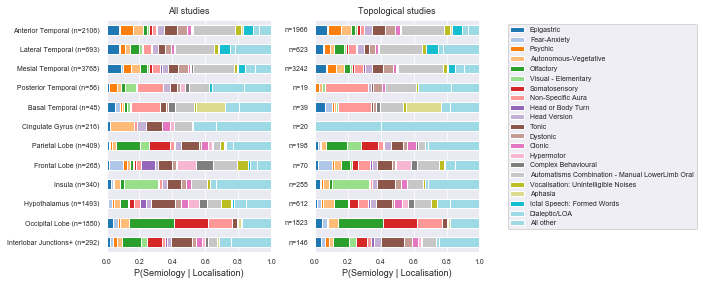

In [105]:
sns.set_style('darkgrid')
# color_palette = sns.color_palette("Paired", 12, as_cmap=True)
color_palette =  sns.color_palette("tab20", as_cmap=True)

fig, axs = plt.subplots(1, 2, sharex=True, sharey=False,)

plot_stacked_hbar(processed_dfs['normalised']['full']['proportion'], ax=axs[0], ax_title='All studies', axis=axis, y_labels=combine_labels_1, color_palette=color_palette)
plot_stacked_hbar(processed_dfs['normalised']['topology']['proportion'], ax=axs[1], ax_title='Topological studies', axis=axis, y_labels=n_labels_2, color_palette=color_palette)

axs[0].get_legend().remove()
axs[1].legend(bbox_to_anchor=(1.15,1), loc="upper left")

plt.tight_layout()
# plt.savefig('/Users/karan/Downloads/fig2_stacked_by_zone_all_other_normalise.png', dpi=300, pad_inches=0.5)

In [106]:
x_labels = ['Epigastric', 'Fear-Anxiety', 'Psychic', 'Autonomic',
       'Olfactory', 'Visual - Elementary', 'Somatosensory',
       'Non-Specific Aura', 'Head or Body Turn', 'Head Version', 'Tonic',
       'Dystonic', 'Clonic', 'Hypermotor', 'Complex Behavioural',
       'Automatisms',
       'Unintelligible Noises', 'Aphasia',
       'Formed Words', 'Dialeptic/LOA', ]

/Users/karan/anaconda3/envs/semiology-vis/lib/python3.9/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


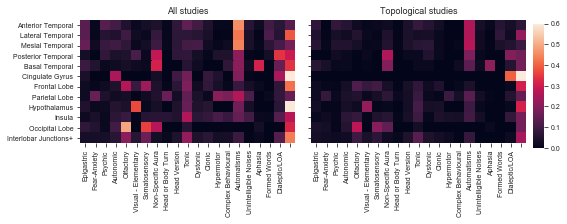

In [107]:
sns.set_style('ticks')
fig, axs = plt.subplots(1, 2, figsize=(7.5, 3), sharey=True, sharex=True)
cbar_ax = fig.add_axes([0.99, .3, .02, 0.576])
cbar_ax.patch.set_edgecolor('black')  
cbar_ax.patch.set_linewidth('1')  

heatmap_kwargs = {
    'square': True,
#      'xticklabels': x_labels
#     'vmin': 0.0,
#     'vmax': 1.0,
}

sns.heatmap(processed_dfs['normalised']['full']['proportion'].T, ax=axs[0], cbar=False, **heatmap_kwargs)
sns.heatmap(processed_dfs['normalised']['topology']['proportion'].T, ax=axs[1], cbar=True, cbar_ax = cbar_ax, **heatmap_kwargs)

axs[0].set_yticklabels(region_names['roi_clean_labels'], rotation=0)
axs[0].set_xticklabels(x_labels)
axs[0].set_title('All studies')
axs[1].set_title('Topological studies')

# fig.colorbar(im, orientation="horizontal", pad=0.2)

plt.tight_layout()
# plt.savefig('/Users/karan/Downloads/heatmap4.png', dpi=300, pad_inches=0.5, bbox_inches = "tight")

# Subplots

In [1144]:
def get_specific_df(query_results, columns_of_interest):
    counts_matrix = []
    for semiology, value in query_results.items():
        query_inspection = value['query_inspection']
        semiology_counts = query_inspection[columns_of_interest].sum().values
        counts_matrix.append(semiology_counts)
    counts_df = pd.DataFrame(counts_matrix, index=query_results.keys(), columns=columns_of_interest)
    return counts_df

In [1303]:
axis='zone'
processed_dfs = {}
# columns_of_interest = ['SSMA', 'SMA (pre-central gyrus; posterior SFG, MFG)', 'FL']
columns_of_interest = ['CING', 'Ant Cing (frontal, genu)', 'Post Cing', ]
# columns_of_interest = ['PL',
#                        'Primary Sensory Cortex (post-central gyrus)',
#                        'medial anterior parietal',
#                        'Sup. pariet. lobule',
#                        'Inferior Parietal Lobule',]

for query_result_name, query_result in query_results.items():
    counts_df = get_specific_df(query_result, columns_of_interest)
    
#     counts_df['SMA'] = counts_df['SSMA'] + counts_df['SMA (pre-central gyrus; posterior SFG, MFG)']
#     counts_df['FL-SMA'] = counts_df['FL'] - counts_df['SMA']
#     counts_df = counts_df.drop(['SMA (pre-central gyrus; posterior SFG, MFG)', 'SSMA'], 1)
    
    counts_df['Cingulate - (anterior + posterior)'] = counts_df['CING'] - (counts_df['Post Cing'] + counts_df['Ant Cing (frontal, genu)'])
    
    counts_df = merge_all_other_semiologies(counts_df, top_20_semiologies)
    proportion_df = calculate_proportions(counts_df, axis)
    confint_dfs = calculate_confint(counts_df, axis = axis, method = 'binomial', alpha=0.05)
    processed_dfs[query_result_name] = {
        'counts': counts_df,
        'proportion': proportion_df,
        'confints': confint_dfs
    }

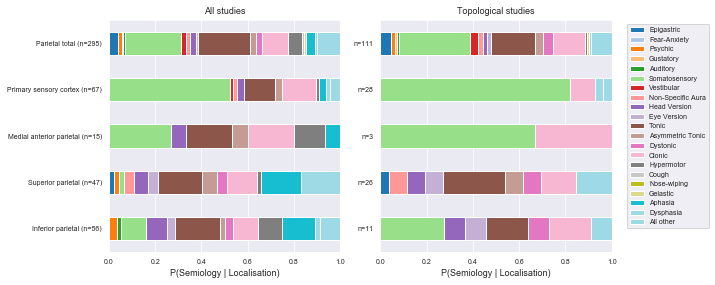

In [1251]:
sns.set_style('darkgrid')
color_palette =  sns.color_palette("tab20", as_cmap=True)

fig, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(20, 2.5))

y_labels = processed_dfs['full']['counts'].columns
# y_labels = ['FL', 'SMA subgroup', 'FL not SMA']
# y_labels = ['Cingulate total', 'Anterior cingulate', 'Posterior cingulate', 'Cingulate not anterior or posterior']
y_labels = ['Parietal total',
 'Primary sensory cortex',
 'Medial anterior parietal',
 'Superior parietal',
 'Inferior parietal']

y_sums_1 = [int(n) for n in processed_dfs['full']['counts'].sum()]
y_sums_2 = [int(n) for n in processed_dfs['not_ss']['counts'].sum()]

combine_labels_1 = [label+f' (n={n})' for n, label in zip(y_sums_1, y_labels)]
n_labels_1 = [f'n={n}' for n in y_sums_1]
n_labels_2 = [f'n={n}' for n in y_sums_2]

plot_stacked_hbar(processed_dfs['full']['proportion'], ax=axs[0], ax_title='All studies', y_labels=combine_labels_1, axis=axis, color_palette=color_palette)
plot_stacked_hbar(processed_dfs['not_ss']['proportion'], ax=axs[1], ax_title='Topological studies', y_labels=n_labels_2, axis=axis, color_palette=color_palette)

axs[0].get_legend().remove()
axs[1].legend(bbox_to_anchor=(1.05,1), loc="upper left")

plt.tight_layout()
plt.savefig('/Users/karan/Downloads/PL.png', dpi=1200, pad_inches=0.5)

# Odds ratio

Fig 3: definitely a Forest plot of odds ratios. 

I.e. Odds of semiology 1 localising to lobe A, divided by odds of NotSemiology A localising to lobe A. NotSemiology can be obtained by removing the result of QUERY_SEMIOLOGY from the original_df.
This gives Relative localising values. Interpret as intrinsic values of a specific semiology vs other semiologies. Narrow clinical history question.

In [177]:
axis='semiology'
regions_of_interest = region_names['low_level_temporal_of_interest']+region_names['of_interest_minus_tl']
semiologies_of_interest = sorted_semiologies[-20:]

processed_dfs = {}
for normalised_or_not, sub_query_results in query_results.items():
    processed_dfs[normalised_or_not] = {}
    for study_type, query_result in sub_query_results.items():
        processed_dfs[normalised_or_not][study_type] = interogate_queries.summarise_query(
            query_result,
            axis = 'semiology',
            region_names = region_names,
            confint_method = 'binomial',
            merge_temporal = False,
            other_included = True,
            semiologies_of_interest = semiologies_of_interest,
            regions_of_interest = regions_of_interest,
            drop_other_semiology = False)

In [178]:
total_row = normalised_raw_dfs['full'][regions_of_interest].sum()
total_row['All other'] = normalised_raw_dfs['full'][region_names['top_level_all_other']].sum().sum()

In [179]:
counts = processed_dfs['normalised']['full']['counts']

In [180]:
total_df = pd.DataFrame([total_row.values for i in range(len(counts))], columns = counts.columns, index=counts.index)

In [209]:
odds1 = counts / (total_df - counts)

In [210]:
odds2 = (total_df - counts) / total_df

In [211]:
odds_ratio = odds1/odds2

In [216]:
counts

,Anterior (temporal pole),Lateral Temporal,Mesial Temporal,Posterior Temporal,Basal (including Fusiform OTMG),Hypothalamus,PL,CING,OL,FL,INSULA,All other
Epigastric,162.333333,53.413596,333.336404,1.000000,2.500000,5.000000,5.083333,3.333333,9.750000,16.916667,77.166667,6.0
Fear-Anxiety,13.904762,3.892157,49.988796,0.000000,1.500000,0.000000,2.500000,23.954286,3.000000,34.426667,57.000000,6.0
Psychic,159.000000,22.500000,185.000000,2.500000,0.500000,0.000000,5.200000,6.666667,3.600000,13.666667,15.000000,6.0
Autonomous-Vegetative,125.871429,19.500000,207.147619,1.333333,0.600000,31.000000,10.666667,4.142857,10.833333,57.238095,107.666667,10.0
Olfactory,60.333333,38.473077,154.610256,1.500000,1.000000,0.000000,60.833333,5.166667,8.250000,75.166667,507.333333,34.0
Visual - Elementary,20.333333,10.000000,39.000000,3.666667,0.666667,0.000000,20.700000,1.000000,70.433333,5.000000,0.500000,10.0
Somatosensory,36.500000,7.000000,61.500000,0.500000,0.500000,0.000000,53.000000,4.000000,2.500000,49.833333,374.333333,27.0
Non-Specific Aura,53.166667,32.133333,201.366667,9.000000,8.500000,4.000000,10.500000,7.500000,7.000000,53.750000,273.750000,5.0
Head or Body Turn,13.166667,4.000000,27.666667,0.000000,0.000000,0.000000,2.000000,23.936797,0.000000,53.896537,0.000000,3.0
Head Version,90.500000,28.000000,151.000000,2.333333,0.000000,12.000000,15.250000,4.333333,9.083333,43.833333,0.333333,8.0


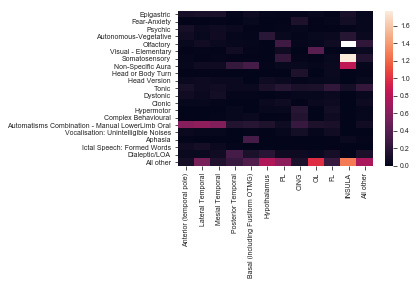

In [223]:
sns.heatmap(odds_ratio[odds_ratio<3])
plt.tight_layout()
plt.savefig('/Users/karan/Downloads/oddsr_hm_v2.png', dpi=300, pad_inches=0.5, cmap='coolwarm')

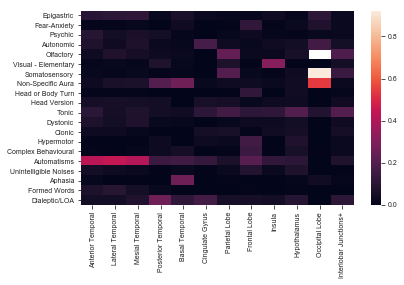

In [202]:
sns.heatmap(odds.drop('All other')[odds.drop('All other')<1], xticklabels=y_names, yticklabels=x_labels)
plt.tight_layout()
plt.savefig('/Users/karan/Downloads/odds_hm_v2.png', dpi=300, pad_inches=0.5)

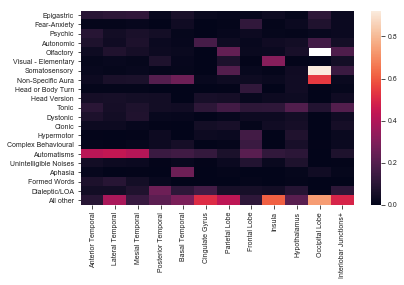

In [206]:
sns.heatmap(odds[odds<1], xticklabels=y_names, yticklabels=x_labels+['All other'])
plt.tight_layout()
plt.savefig('/Users/karan/Downloads/odds_hm_v3.png', dpi=300, pad_inches=0.5)

In [194]:
plot_proportion_ci_forest_plot(proportion_df_1 = processed_dfs['normalised']['full']['proportion'],
                               confint_df_1 = processed_dfs['normalised']['full']['confints'],
                               counts_df_1 = processed_dfs['not_normalised']['full']['counts'],
                               colors = colors,
                               plotter_settings = plotter_settings,
                               legend_labels = legend_labels,
                               proportion_df_2 = processed_dfs['normalised']['spontaneous']['proportion'],
                               confint_df_2 = processed_dfs['normalised']['spontaneous']['confints'],
                               counts_df_2 = processed_dfs['not_normalised']['spontaneous']['counts'],
                               y_labels = y_names,
                               overlapping=False,
                               ax_titles = ax_titles ,
                              )

plt.savefig('/Users/karan/Downloads/forest_normalised_dict1.png', dpi=300, pad_inches=0.5)

['Anterior Temporal',
 'Lateral Temporal',
 'Mesial Temporal',
 'Posterior Temporal',
 'Basal Temporal',
 'Cingulate Gyrus',
 'Parietal Lobe',
 'Frontal Lobe',
 'Insula',
 'Hypothalamus',
 'Occipital Lobe',
 'Interlobar Junctions+']

# NMI/Correlation

In [823]:
counts = processed_dfs['normalised']['full']['counts']
odds = odds_ratio(counts)

(55, 12)

In [821]:
def odds_ratio(counts_df):
    odds_df = copy.deepcopy(counts_df)
    for localisation in counts_df.columns:
        column_sum = counts_df[localisation].sum()
        for semiology in counts_df.index:
            current = counts_df.loc[semiology, localisation]
            sum_minus_current = column_sum - current
            odds_df.loc[semiology, localisation] = current/sum_minus_current
    return odds_df

(55, 12)

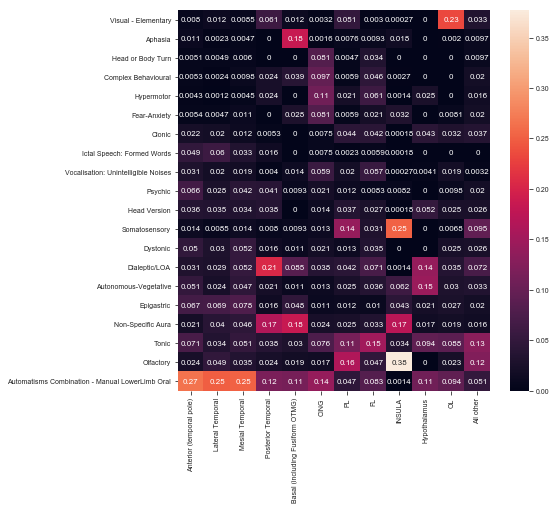

In [836]:
# sns.set_style('ticks')
# fig, axs = plt.subplots(1, 1, figsize=(7.5, 8), sharey=True, sharex=True)
# cbar_ax = fig.add_axes([0.99, .3, .02, 0.576])
# cbar_ax.patch.set_edgecolor('black')  
# cbar_ax.patch.set_linewidth('1')  

# heatmap_kwargs = {
#     'square': True,
# }
sns.set_style('ticks')
fig, ax = plt.subplots(1, figsize=(7, 7))
sns.heatmap(odds.loc[semiologies_of_interest], cbar=True, annot=True)

# axs.set_yticklabels(region_names['roi_clean_labels'], rotation=0)
# axs.set_title('All studies')

# # fig.colorbar(im, orientation="horizontal", pad=0.2)

# plt.tight_layout()
# plt.savefig('/Users/karan/Downloads/heatmap4.png', dpi=300, pad_inches=0.5, bbox_inches = "tight")

In [837]:
counts_df

,Anterior (temporal pole),Lateral Temporal,Mesial Temporal,Posterior Temporal,Basal (including Fusiform OTMG),CING,PL,FL,INSULA,Hypothalamus,OL,All other
Epigastric,148.166667,31.146154,206.437179,0.000000,2.500000,1.333333,3.833333,8.500000,76.666667,0.0,7.750000,5.0
Autonomous-Vegetative,117.800000,17.000000,173.433333,0.333333,0.600000,3.000000,6.166667,42.666667,106.666667,0.0,9.333333,4.0
Olfactory,50.500000,34.973077,117.776923,0.000000,0.000000,3.666667,24.500000,50.500000,505.333333,0.0,5.750000,14.0
Somatosensory,33.500000,5.000000,43.500000,0.000000,0.000000,2.500000,20.500000,32.333333,373.333333,0.0,2.000000,10.0
Non-Specific Aura,45.666667,31.633333,177.866667,5.000000,8.000000,5.000000,7.000000,38.750000,272.250000,0.0,3.500000,4.0
Tonic,165.300000,21.125000,204.975000,0.333333,0.600000,6.333333,15.277778,59.055556,59.000000,0.0,27.666667,20.0
Dystonic,119.800000,22.500000,215.100000,1.000000,0.600000,1.000000,5.000000,7.000000,0.000000,0.0,9.000000,7.0
Automatisms Combination - Manual LowerLimb Oral,515.869048,163.741143,881.782666,3.666667,5.607143,9.833333,8.666667,64.333333,0.000000,0.0,24.166667,12.0
Dialeptic/LOA,70.083333,17.112745,178.303922,3.833333,2.250000,4.000000,3.500000,49.000000,0.000000,8.0,3.583333,3.0
All other,1138.452381,409.980499,1828.043311,8.750000,25.190476,39.333333,113.650000,324.244444,430.533333,12.0,187.433333,79.0


In [775]:
import dython

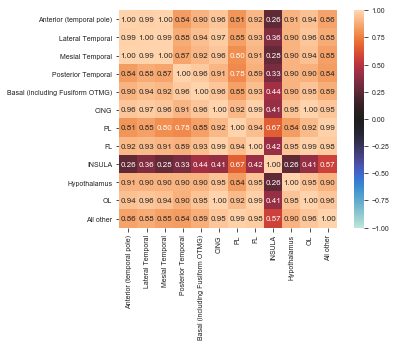

{'corr':                                  Anterior (temporal pole)  Lateral Temporal  \
 Anterior (temporal pole)                         1.000000          0.990158   
 Lateral Temporal                                 0.990158          1.000000   
 Mesial Temporal                                  0.995901          0.994472   
 Posterior Temporal                               0.840019          0.875255   
 Basal (including Fusiform OTMG)                  0.900717          0.935554   
 CING                                             0.958614          0.970846   
 PL                                               0.814266          0.848953   
 FL                                               0.917838          0.926684   
 INSULA                                           0.262681          0.355559   
 Hypothalamus                                     0.905641          0.902420   
 OL                                               0.943314          0.956764   
 All other                      

In [777]:
dython.nominal.associations(counts, theil_u=True)

----
## Junk
----

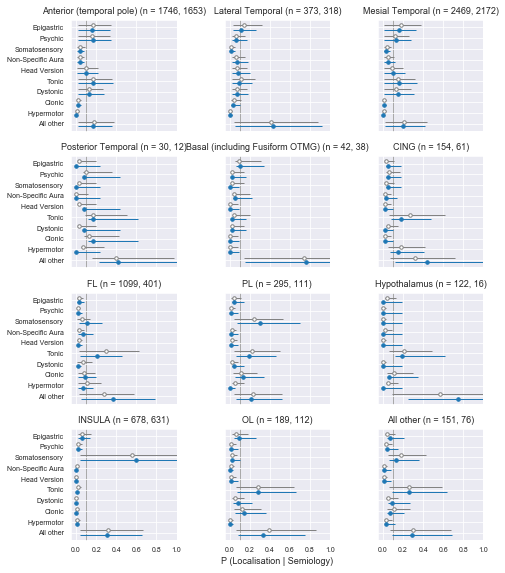

In [988]:
colors = colors

plot_proportion_ci_forest_plot(proportion_df_1 = processed_dfs['full']['proportion'].T,
                               confint_df_1 = processed_dfs['full']['confints'],
                               counts_df_1 = processed_dfs['full']['counts'].T,
                               colors = colors,
                               plotter_settings = plotter_settings,
                               labels = labels,
                               proportion_df_2 = processed_dfs['not_ss']['proportion'].T,
                               confint_df_2 = processed_dfs['not_ss']['confints'],
                               counts_df_2 = processed_dfs['not_ss']['counts'].T,
#                                y_labels = region_names['roi_clean_labels'],
                               overlapping=False
                              )
plt.savefig('/Users/karan/Downloads/weird_by_zone.png', dpi=1200, pad_inches=0.5)

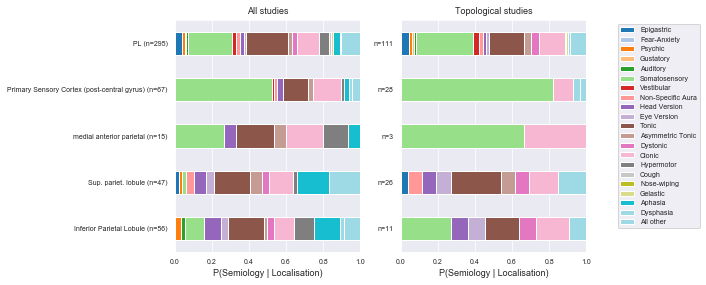

In [1189]:
sns.set_style('darkgrid')
color_palette =  sns.color_palette("tab20", as_cmap=True)

fig, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(5, 3))

y_labels = processed_dfs['full']['counts'].columns
y_sums_1 = [int(n) for n in processed_dfs['full']['counts'].sum()]
y_sums_2 = [int(n) for n in processed_dfs['not_ss']['counts'].sum()]

combine_labels_1 = [label+f' (n={n})' for n, label in zip(y_sums_1, y_labels)]
n_labels_1 = [f'n={n}' for n in y_sums_1]
n_labels_2 = [f'n={n}' for n in y_sums_2]

plot_stacked_hbar(processed_dfs['full']['proportion'], ax=axs[0], ax_title='All studies', y_labels=combine_labels_1, axis=axis, color_palette=color_palette)
plot_stacked_hbar(processed_dfs['not_ss']['proportion'], ax=axs[1], ax_title='Topological studies', y_labels=n_labels_2, axis=axis, color_palette=color_palette)

axs[0].get_legend().remove()
axs[1].legend(bbox_to_anchor=(1.15,1), loc="upper left")

plt.tight_layout()
plt.savefig('/Users/karan/Downloads/SMA.png', dpi=1200, pad_inches=0.5)

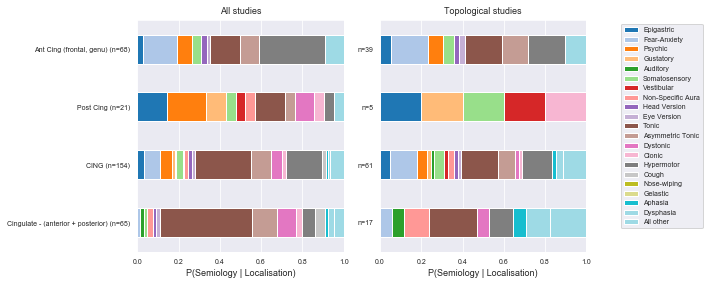

In [307]:
def transpose_if_possible(items):
    transposed_items = []
    try:
        for item in items:
            try:
                transposed_items.append(item.T)
            except AttributeError:
                transposed_items.append(item)
    except TypeError:
        try:
            transposed_items.append(items.T)
        except AttributeError:
            return items
    return transposed_items

In [1170]:
region_names['roi_clean_labels']

['Anterior Temporal',
 'Lateral Temporal',
 'Mesial Temporal',
 'Posterior Temporal',
 'Basal Temporal',
 'Cingulate Gyrus',
 'Frontal Lobe',
 'Parietal Lobe',
 'Hypothalamus',
 'Insula',
 'Occipital Lobe',
 'Interlobar Junctions+']

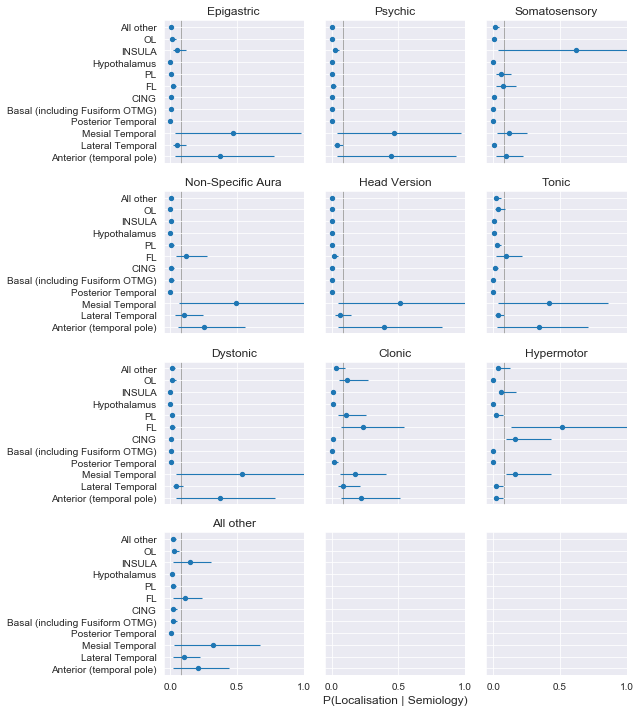

In [212]:
# labels = ['ALl studies', 'Spontaneous Semiology only']
# colors = ['#009988', '#cc3311'] # green, red
# colors = [sns.color_palette("Greys")[3], 'black'] # greys
# colors = [sns.color_palette("Greens")[3], sns.color_palette("Greens")[5]] # greens
# colors = [sns.color_palette("Greys")[4], sns.color_palette("Greens")[5]] # grey-greens
# alphas = [0.9, 1]
# markers = ['o', '^']
vline_color = 'darkgray'

In [ ]:
for j in range(len(x)):
            if j%2 == 0:
                ax.axvspan(0, 1, j/len(x), (j+1)/len(x), facecolor='blue', alpha = 0.3)

In [27]:
def calculate_proportions_by_semiology(counts_df):
    totals_by_zone = counts_df.sum(0)
    proportions_by_zone = counts_df.div(totals_by_zone, axis='columns')
    return proportions_by_zone

In [28]:
def calculate_proportions_by_zone(counts_df):
    totals_by_semiology = counts_df.sum(1)
    proportions_by_semiology = counts_df.div(totals_by_semiology, axis='index')
    return proportions_by_semiology

In [577]:
def calculate_proportions_and_ci(query_results, region_names, merge_temporal = False,  merge_others = True, other_included = True):
    for semiology, value in query_results.items():
#         print(region_names_update)
        query_inspection = value['query_inspection']
        if merge_temporal == False:
            region_names_update =  region_names['low_level_temporal_of_interest'] + region_names['of_interest_minus_tl']
            by_zone_temporal = np.array(query_inspection[region_names['low_level_temporal_of_interest']].sum(0))
            by_zone_minus_temporal = np.array(query_inspection[region_names['of_interest_minus_tl']].sum(0))
            by_zone = np.append(by_zone_temporal, by_zone_minus_temporal)
        else:
            region_names_update = copy.deepcopy(region_names['of_interest'])
            by_zone = np.array(query_inspection[region_names['of_interest']].sum(0))
            
        if other_included and merge_others==True:
            region_names_update += ['All other']
            all_other_zones = query_inspection[region_names['top_level_all_other']].sum(0).sum()
            by_zone = np.append(by_zone, all_other_zones)
            
        elif other_included and merge_others==False:
            region_names_update += region_names['top_level_all_other']
            
        
        if sum(by_zone) != 0:
            proportions = get_proportions(by_zone)
            confint = multinomial_ci.sison(by_zone, alpha=0.05)
#             confint = multinomial_proportions_confint(by_zone, alpha=0.05, method='goodman') #sison-glaz throws error?!
            ci = confint[:,1] - confint[:,0]
        else:
            proportions = by_zone
            confint = by_zone
            ci = by_zone
            
        query_results[semiology]['by_zone'] = by_zone
        query_results[semiology]['proportions'] = proportions
        query_results[semiology]['confint'] = confint
        query_results[semiology]['ci'] = ci
        query_results[semiology]['semiology_name'] = semiology
        query_results[semiology]['region_names'] = region_names_update

    return query_results

In [424]:
standard_qr = copy.deepcopy(semiology_query_results)
standard_qr = calculate_proportions_and_ci(standard_qr, region_names, other_included = True, merge_temporal = False)

In [425]:
spontaneous_qr = copy.deepcopy(semiology_query_results_ss)
spontaneous_qr = calculate_proportions_and_ci(spontaneous_qr, region_names, other_included = True, merge_temporal = False)

In [266]:
roi = standard_qr['Epigastric']['region_names']

In [17]:
def get_proportions(values):
    sum_values = np.sum(values)
    proportions = [value/sum_values for value in values]
    return proportions

In [673]:
for semiology, value in spontaneous_qr.items():
    proportions = value['proportions']
for i in proportions:
    print(i, not_good_bootstrap(i))

0.15384615384615385 (0.1485, 0.1619)
0.07692307692307693 (0.0728, 0.0849)
0.07692307692307693 (0.0721, 0.0811)
0.3076923076923077 (0.2993, 0.324)
0.0 (0.0, 0.0)
0.15384615384615385 (0.149, 0.1646)
0.23076923076923078 (0.2251, 0.2429)
0.0 (0.0, 0.0)
0.0 (0.0, 0.0)
0.0 (0.0, 0.0)
0.0 (0.0, 0.0)
0.0 (0.0, 0.0)


In [671]:
def not_good_bootstrap(proportion, n_bootstraps = 100, alpha = 0.05):
    bootstrap_list = []
    for i in range(n_bootstraps):
        boot = (sum(np.random.rand(10000) <= proportion))/10000
        bootstrap_list.append(boot)
    bootstrap_list = np.array(bootstrap_list)
    bootstrap_list.sort()
    lower_ci = bootstrap_list[int(n_bootstraps*alpha)]
    upper_ci = bootstrap_list[int(n_bootstraps*1-alpha)]
    
    return (lower_ci, upper_ci)

In [391]:
def plot_semiology(x, y_labels, ax, vline_color, **kwargs):
    sns.pointplot(x=x,
                  y=y_labels,
                  ax=ax,
                join=False,
                ci=False,
                **kwargs
                )
#     xerr = query_result['confint'].T
#     ax.errorbar(x, y_labels, xerr=xerr, ls='none', color=colors['plot'], alpha=alpha)
        
    ax.title.set_text(query_result['semiology_name'])
    ax.set_xlim([-0.05,1])
    ax.axvline(x=1/len(x),ymin=0,ymax=1,c=vline_color, linewidth=1, zorder=0, clip_on=False)

In [371]:
main_colors = {'plot': '#009988', 'vline': 'darksalmon'} 
ss_colors = {'plot': '#cc3311', 'vline': 'darksalmon'}
#https://personal.sron.nl/~pault/#sec:qualitative

In [369]:
main_colors = {'plot': '#44aa99', 'vline': 'darksalmon'} 
ss_colors = {'plot': '#cc6677', 'vline': 'darksalmon'}
#https://personal.sron.nl/~pault/#sec:qualitative

In [517]:
labels = ['ALl studies', 'Spontaneous Semiology only']
colors = ['#009988', '#cc3311'] # green, red
colors = [sns.color_palette("Greys")[3], 'black'] # greys
colors = [sns.color_palette("Greens")[3], sns.color_palette("Greens")[5]] # greens
colors = [sns.color_palette("Greys")[4], sns.color_palette("Greens")[5]] # grey-greens
alphas = [0.9, 1]
markers = ['o', '^']
vline_color = 'darkgray'

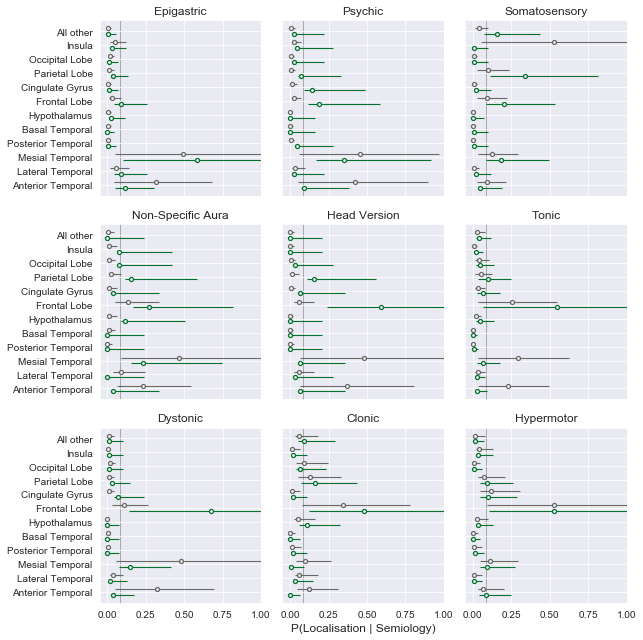

In [518]:
sns.set_style("darkgrid")

fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(9, 9))
for i, semiology in enumerate(top_9_semiologies):
    coord = divmod(i, 3)
    ax = axs[coord[0], coord[1]]
    y_labels = roi_clean_labels
    
    trans1 = Affine2D().translate(0, +0.2) + ax.transData
    trans2 = Affine2D().translate(0, -0.2) + ax.transData
    transforms = [trans1, trans2]
    
    for n_qr, qr in enumerate([standard_qr, spontaneous_qr]):
        query_result = qr[semiology]
        x = query_result['proportions']
        
        xerr = query_result['confint'].T
        ax.errorbar(x,
                    y_labels,
                    xerr=xerr,
                    ls='none',
                    linewidth = 1.1,
                    marker='o',
                    markeredgewidth=1.3,
                    markersize=4,
                    color=colors[n_qr],
                    alpha = alphas[n_qr],
                    markerfacecolor='white',
                    transform=transforms[n_qr])

    ax.title.set_text(query_result['semiology_name'])
    ax.set_xlim([-0.05,1])
    ax.axvline(x=1/len(x),ymin=0,ymax=1,c=vline_color, linewidth=1, zorder=0, clip_on=False)

axs[2, 1].set_xlabel('P(Localisation | Semiology)', ha='center', fontsize=12)
plt.tight_layout()
plt.savefig('/Users/karan/Downloads/figure1_offset_gg.png', dpi=300, pad_inches=0.3)

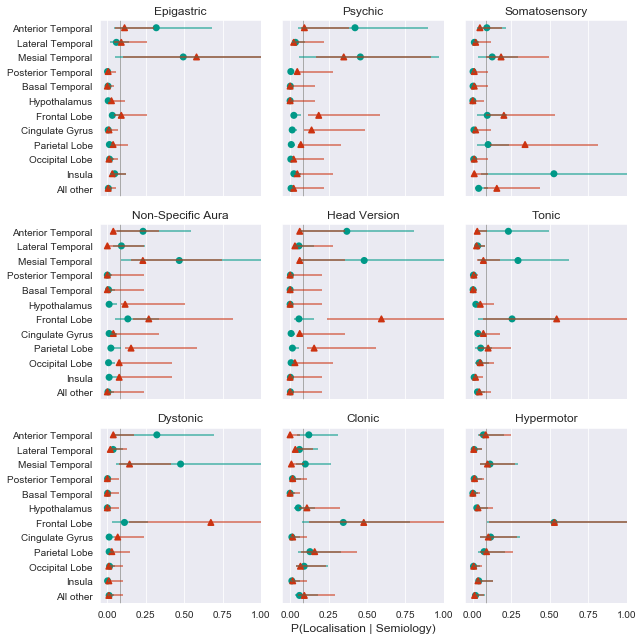

In [438]:
sns.set_style("darkgrid")

fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(9, 9))
for i, semiology in enumerate(top_9_semiologies):
    coord = divmod(i, 3)
    ax = axs[coord[0], coord[1]]
    y_labels = roi_clean_labels
    
    for n_qr, qr in enumerate([standard_qr, spontaneous_qr]):
        query_result = qr[semiology]
        x = query_result['proportions']
        
        xerr = query_result['confint'].T
        ax.errorbar(x, y_labels, xerr=xerr, ls='none', color=colors[n_qr], alpha = 0.7)
        
    for n_qr, qr in enumerate([standard_qr, spontaneous_qr]):
        query_result = qr[semiology]
        x = query_result['proportions']
        plot_semiology(x, y_labels, ax, vline_color, scale=0.8, label=labels[n_qr], color=colors[n_qr], markers=markers[n_qr], transform=transforms[n_qr])

axs[2, 1].set_xlabel('P(Localisation | Semiology)', ha='center', fontsize=12)
plt.tight_layout()
plt.savefig('/Users/karan/Downloads/figure1_overlap_.png', dpi=300, pad_inches=0.3)

In [394]:
# roi = region_names['of_interest_minus_tl'] + region_names['low_level_temporal_of_interest']
# total_by_zone = df[roi].sum(0)
# all_other_total = df[region_names['top_level_all_other']].sum().sum()
# all_other_total = pd.Series([all_other_total], index=['All other'])
# total_by_zone = total_by_zone.append(all_other_total)

In [299]:
count_matrix = []
for semiology in top_9_semiologies:
    count_matrix.append(standard_qr[semiology]['by_zone'])

In [300]:
counts_df = pd.DataFrame(np.array(count_matrix), columns=standard_qr[semiology]['region_names'], index=top_9_semiologies)
# counts_df['sum'] = counts_df.sum(1)
# counts_df.loc['sum'] = counts_df.sum(0)

In [301]:
counts_df

,Anterior (temporal pole),Lateral Temporal,Mesial Temporal,Posterior Temporal,Basal (including Fusiform OTMG),Hypothalamus,FL,CING,PL,OL,INSULA,Any other
Epigastric,288.0,53.0,447.0,1.0,4.0,5.0,29.0,5.0,12.0,13.0,43.0,6.0
Psychic,279.0,23.0,302.0,3.0,1.0,0.0,16.0,9.0,5.0,3.0,16.0,4.0
Somatosensory,65.0,7.0,90.0,1.0,1.0,0.0,67.0,5.0,71.0,4.0,377.0,27.0
Non-Specific Aura,61.0,24.0,123.0,0.0,2.0,3.0,35.0,3.0,6.0,2.0,3.0,1.0
Head Version,173.0,27.0,226.0,1.0,0.0,0.0,27.0,3.0,7.0,3.0,1.0,1.0
Tonic,299.0,41.0,380.0,5.0,2.0,25.0,330.0,42.0,66.0,54.0,11.0,39.0
Dystonic,223.0,26.0,330.0,1.0,1.0,0.0,77.0,8.0,8.0,10.0,1.0,8.0
Clonic,32.0,16.0,26.0,4.0,0.0,14.0,91.0,3.0,34.0,24.0,3.0,16.0
Hypermotor,16.0,2.0,26.0,2.0,0.0,6.0,123.0,27.0,17.0,1.0,9.0,4.0


In [302]:
totals_by_zone = counts_df.sum(0)
totals_by_semiology = counts_df.sum(1)
proportions_by_zone = copy.deepcopy(counts_df)

In [305]:
proportions_by_zone = counts_df.div(totals_by_zone, axis='columns')
proportions_by_semiology = counts_df.div(totals_by_semiology, axis='index')

In [306]:
proportions_by_zone

,Anterior (temporal pole),Lateral Temporal,Mesial Temporal,Posterior Temporal,Basal (including Fusiform OTMG),Hypothalamus,FL,CING,PL,OL,INSULA,Any other
Epigastric,0.200557,0.242009,0.229231,0.055556,0.363636,0.094340,0.036478,0.047619,0.053097,0.114035,0.092672,0.056604
Psychic,0.194290,0.105023,0.154872,0.166667,0.090909,0.000000,0.020126,0.085714,0.022124,0.026316,0.034483,0.037736
Somatosensory,0.045265,0.031963,0.046154,0.055556,0.090909,0.000000,0.084277,0.047619,0.314159,0.035088,0.812500,0.254717
Non-Specific Aura,0.042479,0.109589,0.063077,0.000000,0.181818,0.056604,0.044025,0.028571,0.026549,0.017544,0.006466,0.009434
Head Version,0.120474,0.123288,0.115897,0.055556,0.000000,0.000000,0.033962,0.028571,0.030973,0.026316,0.002155,0.009434
Tonic,0.208217,0.187215,0.194872,0.277778,0.181818,0.471698,0.415094,0.400000,0.292035,0.473684,0.023707,0.367925
Dystonic,0.155292,0.118721,0.169231,0.055556,0.090909,0.000000,0.096855,0.076190,0.035398,0.087719,0.002155,0.075472
Clonic,0.022284,0.073059,0.013333,0.222222,0.000000,0.264151,0.114465,0.028571,0.150442,0.210526,0.006466,0.150943
Hypermotor,0.011142,0.009132,0.013333,0.111111,0.000000,0.113208,0.154717,0.257143,0.075221,0.008772,0.019397,0.037736


In [363]:
color_palette = sns.color_palette("Paired", 12, as_cmap=True)

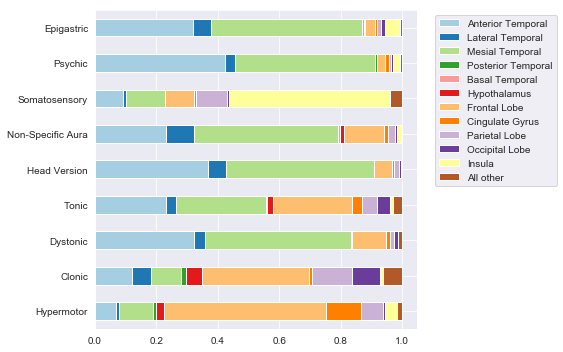

In [531]:
sns.set_style('darkgrid')

# fig, axs = plt.subplots(1, figsize=(8, 5))
proportions_by_semiology.columns = roi_clean_labels
proportions_by_semiology[::-1].plot(kind='barh', colormap=color_palette, stacked=True, figsize=(8, 5))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.tight_layout()
plt.savefig('/Users/karan/Downloads/fig2_stacked_by_semiology.png', dpi=300, pad_inches=0.3)

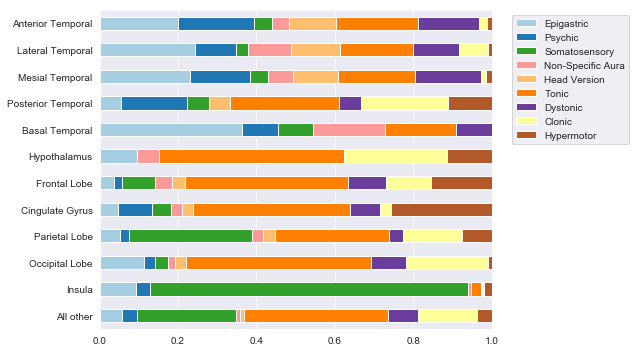

In [539]:
# fig, axs = plt.subplots(1, figsize=(5, 5))
sns.set_style('darkgrid')
proportions_by_zone.columns = roi_clean_labels
proportions_by_zone.T[::-1].plot(kind='barh', colormap=color_palette, stacked=True, figsize=(9, 5))
plt.gca().set_xlim((0,1))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.tight_layout()
plt.savefig('/Users/karan/Downloads/fig2_stacked_by_zone.png', dpi=300, pad_inches=0.5)

In [364]:
def plot_from_table(colors, ax, axis_title, **kwargs):
    alpha=0.8
    scale=0.9
    sns.pointplot(
                join=False,
                ci=False,
                ax=ax,
                color=colors['plot'],
                alpha=alpha,
                scale=scale,
#                   marker='triangle_up',
                **kwargs
                )
#     xerr = query_result['confint'].T
#     ax.errorbar(x, y, xerr=xerr, ls='none', color=colors['plot'], alpha=alpha)
        
    ax.title.set_text(axis_title)
    ax.set_xlim([-0.05,1])
    ax.axvline(x=1/len(kwargs['x']),ymin=0,ymax=1,c=colors['vline'], linewidth=1, zorder=0, clip_on=False)

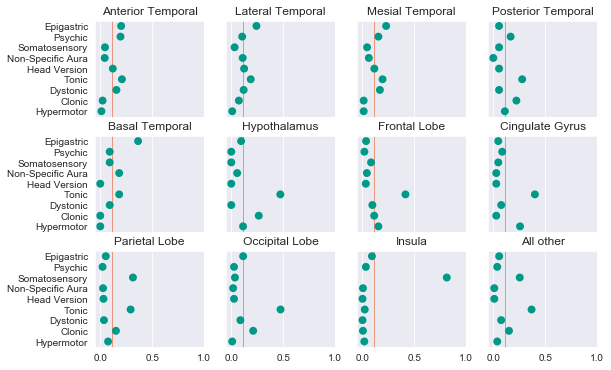

In [366]:
sns.set_style("darkgrid")

fig, axs = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(9, 6))
for i, region in enumerate(roi_clean_labels):
    coord = divmod(i, 4)
    plot_from_table(colors=main_colors,
                    ax = axs[coord[0],coord[1]],
                    axis_title = region,
                    x=proportions_by_zone[region].values,
                    y=proportions_by_zone[region].index,
                    markers='o',
                    )

    
    
#     plot_semiology(proportions_by_zone[semiology], colors=ss_colors, ax = axs[coord[0], coord[1]], label='Spontaneous Semiology', markers='o')
#     plot_semiology(standard_qr[semiology], colors=main_colors, ax = axs[coord[0], coord[1]], label='All studies', markers='^')

# fig.text(0.5, 0.07, 'P(Localisation | Semiology)', ha='center', fontsize=12)
# plt.savefig('/Users/karan/Downloads/figure.png', dpi=300, pad_inches=0.3)

--------------------------------------------
SCRATCH
--------------------------------------------

In [ ]:
[roi[i] for i in my_order]

In [ ]:
regions_of_interest = ['Mesial Temporal',
                         'Lateral Temporal',
                         'Anterior (temporal pole)',
                         'Posterior Temporal',
                         'TL',
                         'FL',
                         'PL',
                         'OL',
                         'INSULA',
                         'CING',
                        ]
# regions_of_interest.sort()
temporal_regions = ['Anterior (temporal pole)',
 'Lateral Temporal',
 'Mesial Temporal',
 'Posterior Temporal']



In [29]:
all_regions = """TL
Anterior (temporal pole)
Lateral Temporal
STG (includes Transverse Temporal Gyrus, Both Planum)
Transverse Temporal Gyrus (Heschl's, BA 41,  42, ?opercula)
Planum Temporale
Planum Polare
MTG
ITG
Mesial Temporal
Ant Mesial Temporal
Post Mesial Temporal
Enthorinal Cortex
Fusiform
AMYGD
PARAHIPPOCAMPUS
HIPPOCAMPUS
Posterior Temporal
Basal (including Fusiform OTMG)
OTMG (fusiform)
FL
frontal pole
Pre-frontal (BA 8, 9, 10, 11, 12, 13, 14, 24, 25, 32, 44, 45, 46, 47)
DL-PFC (BA 46) (include subgroups BA 9, 8, 10 - frontopolar/anterior prefrontal)
gyrus rectus (basal = gyrus rectus and OFC)
Orbito-frontal (BA 10, 11, 12/47) (basal = gyrus rectus and OFC)
Post OF
Lat OF
Med OF
Medial Frontal (include medial premotor and its constituents as its subsets)
Primary Motor Cortex (Pre-central gyrus, BA 4, Rolandic)
medial precentral
Rolandic Operculum (low BA4)
SFG (F1)
Med SFG
Post SFG
Ant SFG
MFG (F2)
Ant MFG
Mid MFG
Post MFG
Pars Triangularis (subgroup IFG)
Pars opercularis (BA 44)(subgroup IFG, ?opercula)
Premotor frontal (posterior frontal)
Ant Premotor (BA 8, frontal-eye-fields)
Medial Premotor (including pre SMA)
SMA (pre-central gyrus; posterior SFG, MFG)
SSMA
CING
Cingulum (WM)
Ant Cing (frontal, genu)
Dorsal Ant Cing (BA 32)
Middle Cingulate
Post Cing
Isthmus
PL
Primary Sensory Cortex (post-central gyrus)
medial anterior parietal
Sup. pariet. lobule
Precuneus (medial post sup parietal lobule)
Inferior Parietal Lobule
Supramarg gyrus (post part of parietal operculum)
Angular gyrus (BA 39)
parietal operculum (ceiling of secondary somatosensory cortex)
OL
Mesial Occipital
Lingual gyrus  (medial and basal)
Cuneus
Lateral Occipital (SOG, IOG, LOG)
Posterior Occipital Gyrus
Superior Occipital Gyrus
INSULA
Ant Ins
Anterior Short Gyrus
Middle Short Gyrus
Post short gyrus
Precentral gyrus
Postcentral gyrus
Posterior long gyrus
Hypothalamus
Sub-Callosal Cortex
Cerebellum
Hemisphere
Vermis
FT
TO
TP
FTP
TPO Junction
PO
FP
Perisylvian""".splitlines()

all_regions += ['''IFG (F3)
(BA 44,45,47)''',
'''Lateral Premotor
(BA 6)''',
'''Pars orbitalis (subgroup of IFG)
(BA 47)''']
# '''Pars opercularis (BA 44)(subgroup IFG, ?opercula)'''

In [ ]:
other_regions = set(all_regions) - set(regions_of_interest)
other_regions = list(other_regions)

regions_of_interest_minus_temporal = set(regions_of_interest) - set(temporal_regions)
regions_of_interest_minus_temporal = list(regions_of_interest_minus_temporal)